# Generative Adversarial Network

[Credit : This notebook was copied and modified from Udacity Deep Learning course]

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:

* [Pix2Pix](https://affinelayer.com/pixsrv/) 
* [CycleGAN](https://github.com/junyanz/CycleGAN)
* [A whole list](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes fake data to pass to the discriminator. The discriminator also sees real data and predicts if the data it's received is real or fake. The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real data. And the discriminator is trained to figure out which data is real and which is fake. What ends up happening is that the generator learns to make data that is indistiguishable from real data to the discriminator.

![GAN diagram](assets/gan_diagram.png)

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector the generator uses to contruct it's fake images. As the generator learns through training, it figures out how to map these random vectors to recognizable images that can fool the discriminator.

The output of the discriminator is a sigmoid function, where 0 indicates a fake image and 1 indicates an real image. If you're interested only in generating new images, you can throw out the discriminator after training. Now, let's see how we build this thing in TensorFlow.

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from IPython.display import clear_output


## Load Training And Valiation Data Sets

In [37]:
batch_size = 32

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('./datasets', download=True, train=True, transform=transform)

valset = datasets.MNIST('./datasets', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

  0%|          | 49152/9912422 [00:00<00:21, 459689.73it/s]

9920512it [00:00, 14571100.70it/s]                            


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 102539.98it/s]
  1%|          | 16384/1648877 [00:00<00:10, 155638.37it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw


1654784it [00:00, 219760.64it/s]                           
0it [00:00, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw


8192it [00:00, 29510.21it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw
Processing...
Done!


## Display A Few Images From The Training Data

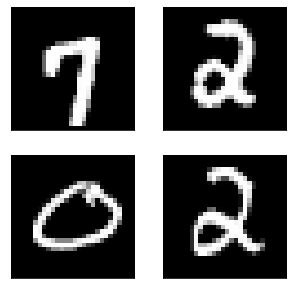

In [38]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(figsize=(5,5), nrows=2, ncols=2, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), images[12:16]):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.detach().numpy().reshape((28,28)), cmap='Greys_r')

## Generator network

![GAN Network](assets/gan_network.png)

Here we'll build the generator network. To make this network a universal function approximator, we'll need at least one hidden layer. We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.


#### Leaky ReLU
Leaky ReLU comes with a parameter, alpha, that defines the negative slope of the function.  Use a small value, such as 0.01.


#### Tanh Output
The generator has been found to perform the best with $tanh$ for the generator output. This means that we'll have to rescale the MNIST images to be between -1 and 1, instead of 0 and 1.

>**Exercise:** Implement the generator network in the function below. You'll need to return the tanh output. 

In [39]:
class Generator(nn.Module):
    def __init__(self, z, out_dim, hidden_size=128, alpha=0.01):
        super(Generator, self).__init__()
        
        ### Student code starts
        
        self.map1 = nn.Linear(z, hidden_size)
        self.map2 = nn.Linear(hidden_size, out_dim)
        
        ### Student code ends
        
    def forward(self, x):
        
        ### Student code starts
        
        x = self.map1(x)
        m = nn.LeakyReLU(alpha)
        x = m(x)
        x = self.map2(x)
        m = nn.Tanh()
        out = m(x)
        
        ### Student code ends
        
        return out

## Discriminator

The discriminator network is almost exactly the same as the generator network, except that we're using a sigmoid output layer.

>**Exercise:** Implement the discriminator network in the function below. Same as above, you'll need to return both the logits and the sigmoid output. 

In [40]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size=128, alpha=0.01):
        super(Discriminator, self).__init__()
        
        ### Student code starts
        
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, 1)
        
        ### Student code ends
        
    def forward(self, x):
        
        ### Student code starts
        
        x = self.map1(x)
        m = nn.LeakyReLU(alpha)
        x = m(x)
        logit = self.map2(x)
        m = nn.Sigmoid()
        out = m(logit)
        
        ### Student code ends
        
        return logit, out

## Hyperparameters

In [62]:
input_size = 784        # size of an input image (flattened)
z_size = 100            # size of random noise vector
g_hidden_size = 128     # size of hidden layer in generator
d_hidden_size = 128     # size of hidden layer in discriminator
alpha = 0.01            # leaky ReLU alpha value
num_epochs = 100        # number of iterations
smooth = 0.1            # label smoothing value
learning_rate = 0.001   # learning rate

## Build network

Now we're building the network from the functions defined above.

We'll create the generator, `Generator(z_size, input_size)` and additional parameters as necessary. This builds the generator with the appropriate input and output sizes.

Then the discriminator, `Discriminator(input_size)` and additional parameters as necessary. 

>**Exercise:** Build the network from the classes you defined earlier.

In [63]:
### Student code starts for generator and discriminator definitions

g_model = Generator(z_size, input_size, hidden_size=g_hidden_size, alpha=alpha)

d_model = Discriminator(input_size, hidden_size=d_hidden_size, alpha=alpha)

### Student code ends

g_optimizer = optim.Adam(g_model.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(d_model.parameters(), lr=learning_rate)

criterion = nn.BCEWithLogitsLoss()


## Training and Determining Discriminator and Generator Losses

Now we need to calculate the losses, which is a little tricky. For the discriminator, the total loss is the average of the losses for real and fake images, `d_loss = (d_loss_real + d_loss_fake) / 2`. 

For the real image logits, we'll use `d_logits_real` which we got from the discriminator in the cell above. For the labels, we want them to be all ones, since these are all real images. To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9, for example,  using the parameter `smooth`. This is known as label smoothing, typically used with classifiers to improve performance. In PyTorch, it looks something like `labels = torch.ones_like(tensor) * (1 - smooth)`

The discriminator loss for the fake data is similar. The logits are `d_logits_fake`, which we got from passing the generator output to the discriminator. These fake logits are used with labels of all zeros. Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

Finally, the generator losses are using `d_logits_fake`, the fake image logits. But, now the labels are all ones. The generator is trying to fool the discriminator, so it wants to discriminator to output ones for fake images.

>**Exercise:** Train the generator and discriminator.  Calculate the losses for the discriminator and the generator. There are two discriminator losses, one for real images and one for fake images. For the real image loss, use the real logits and (smoothed) labels of ones. For the fake image loss, use the fake logits with labels of all zeros. The total discriminator loss is the sum of those two losses. Finally, the generator loss again uses the fake logits from the discriminator, but this time the labels are all ones because the generator wants to fool the discriminator.

In [64]:
# Create 4 random vectors over -1,1.. size =100
z_vector = 2*torch.rand(60, 100)-1 # np.random.uniform(-1, 1, size=(16, z_size))

# Plot 16 images and also plot discriminator/generator loss curves...
    
def viz_network(epoch, dloss_curve, gloss_curve, z_vector, generator) :
    clear_output(True)
    
    # Set the plot size here .. about 4units/row ()
    plt.figure(figsize=[20,20])
    # plt.figure().subplots_adjust(hspace=1, wspace=1)
    
    # First plot the loss curves and accuracy
    ax1 = plt.subplot(5,2,1)
    ax2 = plt.subplot(5,2,2)

    ax1.plot( gloss_curve, label="Generator Loss")
    ax1.legend()
    ax1.set_title('Generator Loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('Loss')
    #acc
    ax2.plot( dloss_curve, label="Discriminator Loss")
    ax2.legend()
    ax2.set_title('Discriminator Loss')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')

    # Now plot 4 images from the generator (same every time to see progression !)
    gen_samples = generator(z_vector) # NCHW
    print(gen_samples.size())
    
    for i in range(8):
        axi = plt.subplot(5,2,i+3)
        img = gen_samples[i]
        axi.imshow(img.detach().numpy().reshape((28,28)), cmap='Greys_r')
        axi.xaxis.set_visible(False)
        axi.yaxis.set_visible(False)
    
    
    plt.show()

torch.Size([60, 784])


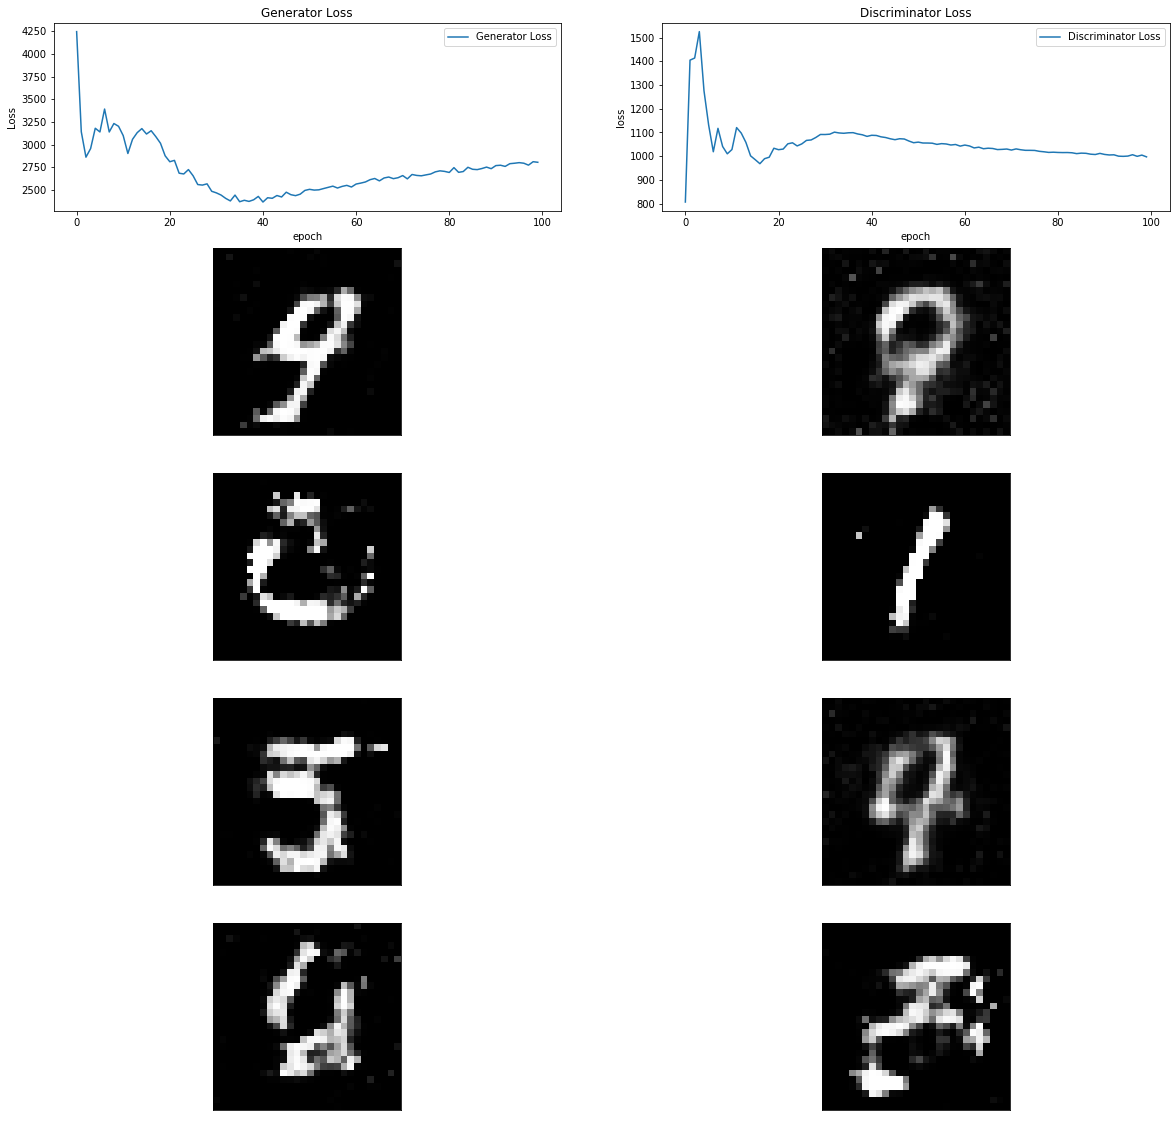

epoch 100


In [65]:
samples = []

gloss_curve = []
dloss_curve = []


for epoch in range(num_epochs):
    
    dloss_epoch = 0
    gloss_epoch = 0
    for real_images, labels in trainloader:
        
        # Train the generator
        if real_images.shape[0] != batch_size:
            break
        
        g_optimizer.zero_grad()
        
        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        batch_z = torch.from_numpy(batch_z)
        batch_z = batch_z.float()
        
        ### Student code starts to train generator
        
        g_fake_images = g_model(batch_z)
        
        d_fake_logit, d_fake_out = d_model(g_fake_images)
        
        one_labels = torch.ones_like(d_fake_logit) * (1 - smooth)
        
        g_loss = criterion(d_fake_logit, one_labels)
        ### Student code ends
        
        g_loss.backward()
        g_optimizer.step()
        
        # Train the discriminator
        d_optimizer.zero_grad()
        
        real_images = real_images.view(real_images.shape[0], -1)
        
        ### Student code starts to train discriminator with real images
    
        d_real_logit, d_real_out = d_model(real_images)
        d_real_loss = criterion(d_real_logit, one_labels)
        
        ### Student code starts to train discriminator with fake images
        
        d_fake_images = g_model(batch_z).detach()
        d_fake_logit, d_fake_out = d_model(d_fake_images)
        zero_labels = torch.zeros_like(d_fake_logit)
        d_fake_loss = criterion(d_fake_logit, zero_labels)
        
        ### Student code starts to combine losses from training with real and fake images
        
        d_loss = (d_real_loss + d_fake_loss) / 2
        
        ### Student code ends
        
        d_loss.backward()
        d_optimizer.step()
        
        dloss_epoch += d_loss
        gloss_epoch += g_loss
        
    # Loss Curves
    gloss_curve.append(gloss_epoch)
    dloss_curve.append(dloss_epoch)
    
    # plot intermediate results !
    viz_network(epoch, dloss_curve, gloss_curve, z_vector, g_model) 
   
    
    
    # Save several samples of generator's output after each epoch
    # sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    # sample_z = torch.from_numpy(z_vector).float()
    gen_samples = g_model(z_vector)
    samples.append(gen_samples)
        
    print("epoch", epoch+1)
           
        
    
    

## Generator samples from training

Here we can view samples of images from the generator. 

Below I'm showing the generated images as the network was training, every 10 epochs. 

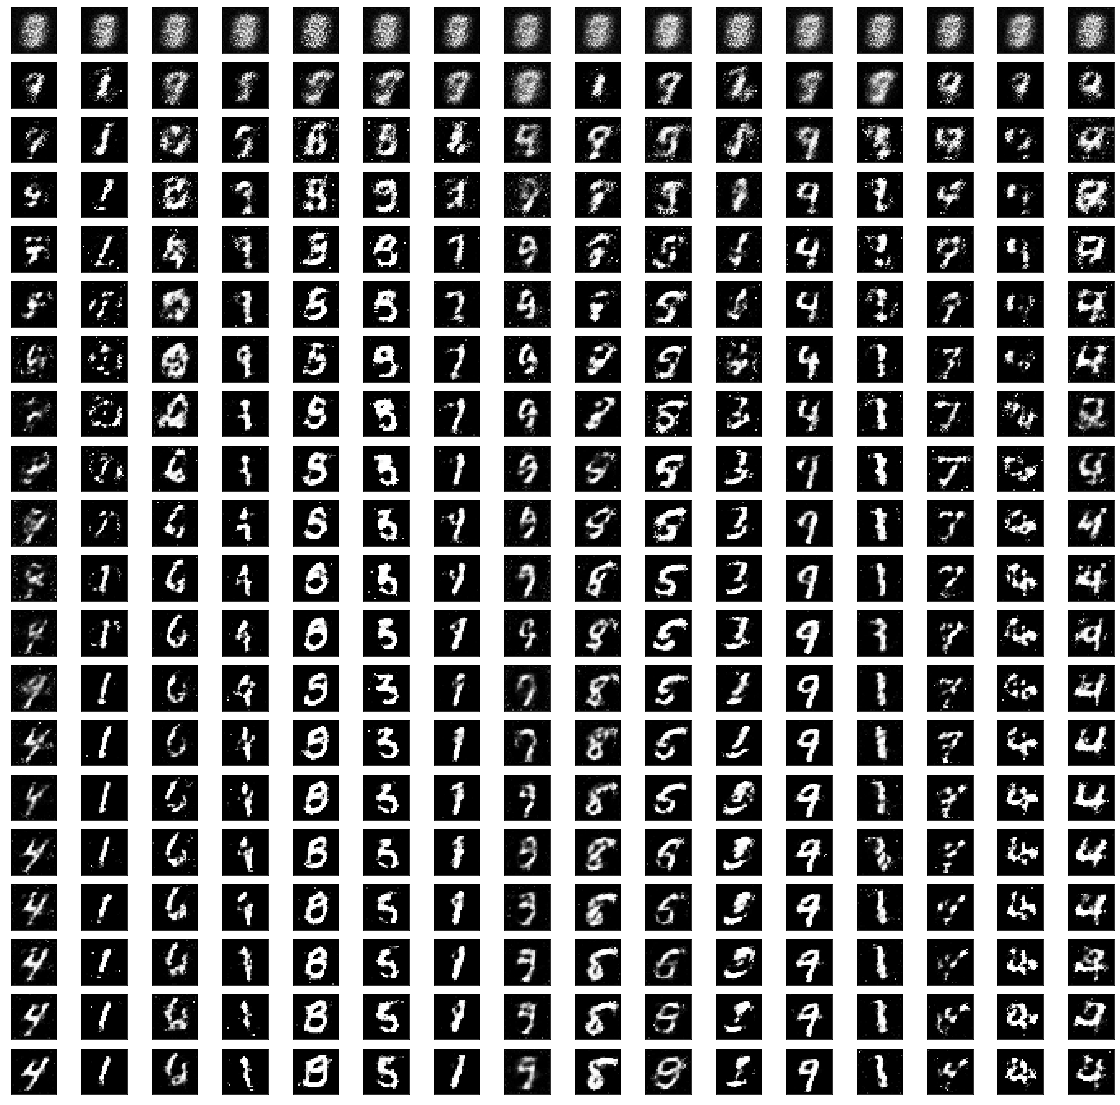

In [66]:
rows, cols = 20, 16
fig, axes = plt.subplots(figsize=(20,20), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.detach().numpy().reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [59]:
len(samples)
len(samples[::10])

10

These are samples from the final training epoch. You can see the generator is able to reproduce several fashion categories. Since this is just a sample, it isn't representative of the full range of images this generator can make.

In [11]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.detach().numpy().reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

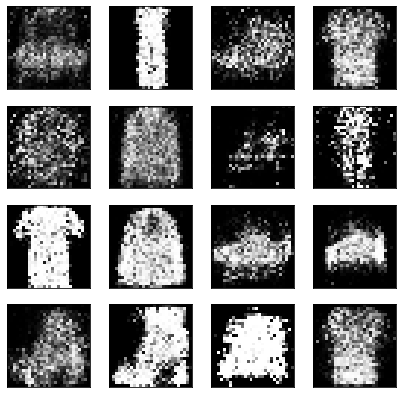

In [12]:
_ = view_samples(-1, samples)

In [ ]:
## Whats next ? 

So how could we make this better ? 